# Imports

In [1]:
import requests
import re
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from http import HTTPStatus

### Utility functions
# the plotting function below helps avoid code duplication as I have few plots with
# this common code. I have decided to put it here to avoid any error in plotting cells.
# this plot function below will plot data for a specific variable from a dataframe
# for all areas(region/Nation) after grouping by "date" and "area".
def plot_area_data(dataframe, variable):
    df_get_data = dataframe[['date','area',str(variable)]]
    df = df_get_data.groupby(by=["date","area"]).sum()
    df.reset_index(inplace=True)
    areas = df['area'].unique()
    plt.figure(figsize=(10,10))
    for area in areas:
        filter_area = df[df["area"]==str(area)]
        plt.plot(filter_area['date'],filter_area[str(variable)],label=str(area))
        plt.legend(loc="best")

## Open Data COVID-19 API

In [2]:

BASE_URL = "https://api.coronavirus.data.gov.uk/v1/data?"

def get_API_data(filters,structure):
    
    """ Return all data provided by the API that matched the query
    
    This function sends API requests to retrieve the Coronavirus data according to
    the parameters passed into the function. it gets all available information
    in every page.
    
    Keyword arguments:
    
        filters: dict
            this parameter defines the filter to be passed on to the query. the 
            details of the filter is given in the API documentation. The filter
            parameter defines things like the location or the date of the data.

        structure: dict
            the structure parameter defines what information should be retreived about 
            the filters specified. The metrics for this parameter are also specified
            in the API documentation.
        
    Returns:
    
        The function returns a list of dictionary containing data which satisfies
        the conditions in both the "filters" and "structure" parameters.
           
    """
    # if someone inputs the "filters" as a list(similar to API) then we can convert it 
    # into a dict. The "structure" in API is of type dict,so we can expect a dict input.  
    if isinstance(filters, list):
        filters_converted = {} 
        for item in filters:
            # if we have a list of string like ['areaType:nation',...] the we 
            # split it using regex expression then format it as desired
            sub_string = re.split(r'[=:-]', item)
            filters_converted[sub_string[0].strip()]=sub_string[1].strip()
        filters=filters_converted
    
    api_dict = {}   
    api_dict['url'] = BASE_URL
    all_filter = "filters="
    all_structure = "structure="
    counter = 0
    for key,value in filters.items():
        #until the end of the "filters" string use ';' at the end use '&'
        if counter<len(filters)-1:
            all_filter+= str(f"{key.strip()}={value.strip()};")
            counter+=1
        else:
            all_filter+= str(f"{key.strip()}={value.strip()}&")      
    api_dict["filter"] = all_filter
    
    # adding "structure" to 'api_dict' removing all unncessary whitespaces to avoid errors
    structure_stripped = {metric.strip():val.strip() for metric,val in structure.items()}
    api_dict["structure"] = "structure=" + str(json.dumps(structure_stripped))
    
    # now we want to loop through all the pages to get all available data
    # while loop is adapted from the example given in the documentation
    all_data = []
    page_number = 1
    while True:
        api_dict["page_number"] = "&page=" + str(page_number)
        api_query_url = "".join(str(val) for val in api_dict.values())
        # getting the API data
        response = requests.get(api_query_url) 
        # API respose error handeling
        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break
        current_data = response.json()
        all_data.extend(current_data['data'])
        # we expect the last page of to have a "None" value for "next" attribute
        # if the"next" attribute of "pagination" is "None" then we break from loop.
        if current_data["pagination"]["next"] is None:
            break
        # increment the page number to go to the next page    
        page_number += 1
        
    return all_data


In [3]:
common_structure = {
                    "date": "date",
                    "name": "areaName",
                    "daily_cases": "newCasesBySpecimenDate",
                    "cumulative_cases": "cumCasesBySpecimenDate",
                    "daily_deaths": "newDeaths28DaysByPublishDate",
                    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
                    "cumulative_vaccinated":"cumPeopleVaccinatedCompleteByVaccinationDate",
                    "vaccination_age": "vaccinationsAgeDemographics"
                    }

# National level data
results_json_national = get_API_data({'areaType':'nation'}, common_structure)
# Regional level data                           
results_json_regional = get_API_data({'areaType':'region'}, common_structure)                   


## Shaping the COVID data into different dataframes

In [4]:
combined_results = results_json_national + results_json_regional

In [5]:
covid_data = pd.DataFrame(combined_results)

In [6]:
covid_data.drop(covid_data[covid_data["name"]=='England'].index,inplace=True)

In [7]:
covid_data.rename(columns={"name": "area"},inplace=True)

In [8]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

In [9]:
# Handeling missing data
# when it comes to missing data I will consider 'NaN' entries as a missing data 
# other values such as a value of '0' should not be considered as missing data
# because it carries important information, a daily case of 0 for example could mean
# that 0 cases were present. In the dataframe 'covid_data' all columns have a data type
# of 'float' except "date"(datetime), "area"(object) and "vaccination_age" which is a list
# object. the columns date and area have no missing value and summary statistics like 
# "Mean" or "std" does not make much sense therefore I will not include them in my summary.
# however for the "vaccination_age" column it would be useful for us to know how many columns 
# have data missing(i.e empty lists) therefore I have included "vaccination_age" in my summary.

# calculate summary statistics of all columns excluding date column
summary_df = covid_data.describe(exclude = ['datetime'])

#remove statistical measures that don't carry significant meaning for this dataset
summary_df.drop(labels=["unique", "top", "freq"],axis=0, inplace=True)
summary_df.drop(columns=["area"], axis=1, inplace=True)

# we can use inull() or isna() method to find missing values
no_of_missing_val = covid_data.isna().sum()[summary_df.columns]
#transpose the df for easier dataframe manipulation
summary_df = summary_df.T

#counting the number of empty lists in 'vaccination_age' column
empty_count = 0
for list_item in covid_data['vaccination_age']:
    # if list is empty
    if not list_item:
        empty_count+=1
        
# now I will add the missing values and also add missing value count for 'vaccination_age'
summary_df['amount of missing data'] = list(no_of_missing_val)[:-1]+[empty_count]

#printing the summary dataframe as asked 
print(summary_df)

                        count            mean             std  min       25%  \
daily_cases            8634.0     2036.003706      3423.43476  0.0     165.0   
cumulative_cases       8634.0   348181.488534   411284.755885  1.0  28605.75   
daily_deaths           6868.0       17.597554       31.376042  0.0       1.0   
cumulative_deaths      6901.0     8562.068686     5538.088781  1.0    4112.0   
cumulative_vaccinated  4210.0  2492537.142755  1948148.167365  1.0  236677.5   
vaccination_age          8647             NaN             NaN  NaN       NaN   

                             50%        75%        max  amount of missing data  
daily_cases                768.0     2694.0    40179.0                      13  
cumulative_cases        208823.5  537745.75  2426973.0                      13  
daily_deaths                 7.0       19.0      378.0                    1779  
cumulative_deaths         7120.0    13424.0    22363.0                    1746  
cumulative_vaccinated  2747570.0  

In [10]:
# Now, we are replacing missing values with the most recent value
# for that area. for this we need to first sort by date(ascending) then 
# group by region and then use the method 'ffill'(i.e forward fill)
covid_data['date'] = pd.to_datetime(covid_data['date'])
covid_data.sort_values(by=['date'],ascending=True,inplace=True)

covid_data['cumulative_deaths'] = (covid_data
                                   .groupby(['area'])['cumulative_deaths']
                                   .ffill())

covid_data['cumulative_cases'] = (covid_data
                                  .groupby(['area'])['cumulative_cases']
                                  .ffill())

covid_data['cumulative_vaccinated'] = (covid_data
                                       .groupby(['area'])['cumulative_vaccinated']
                                       .ffill())

In [11]:
#We remove rows where at least one of the cumulative metrics column values are missing
covid_data.dropna(subset=['cumulative_deaths','cumulative_cases',
                          'cumulative_vaccinated'],axis=0,inplace=True)

In [12]:
#Create 7 days simple rolling average
covid_data["daily_cases_roll_avg"] = (covid_data
                                      .groupby(['area'])['daily_cases']
                                      .transform(lambda x: x.rolling(7).mean()))

covid_data["daily_deaths_roll_avg"] = (covid_data
                                       .groupby(['area'])['daily_deaths']
                                       .transform(lambda x: x.rolling(7).mean()))

In [13]:
# ignored error becuase if the column already dropped then re-executing code causes error
covid_data.drop(columns=['daily_deaths','daily_cases'],axis=1,inplace=True,errors='ignore')

In [14]:
covid_data_vaccinations = covid_data[['date','area','vaccination_age']].copy()
covid_data.drop(columns=['vaccination_age'], axis=1, inplace=True,errors='ignore')

In [15]:
# making a copy of the required dataframe
covid_data_vaccinations_wide = covid_data_vaccinations.copy()

# transforming the dataframe such that each row has vaccination data for a specific date, area
#  and age interval.
grouped_df = (covid_data_vaccinations_wide
              .groupby(['date','area'])
              .vaccination_age.apply(lambda item: pd.DataFrame(item.values[0]))
              .reset_index())

# we can now merge our 'covid_data_vaccinations' copy and the grouped data 
covid_data_vaccinations_wide = (covid_data_vaccinations_wide
                                .merge(grouped_df, how='left', on=['date', 'area']))

#drop the extra columns that are not listed in the specification.
covid_data_vaccinations_wide.drop(columns=['vaccination_age','level_2',
                                    'cumPeopleVaccinatedThirdInjectionByVaccinationDate',
                                    'newPeopleVaccinatedThirdInjectionByVaccinationDate',
                                    'cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage'],
                                    inplace=True)


## Aggregating, plotting, and analysing

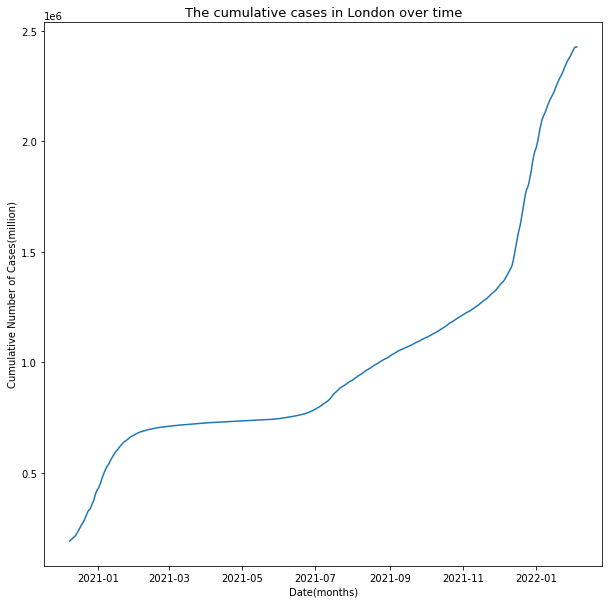

In [16]:
# 1. data aggregation - London Cumulative cases
cumulative_cases = covid_data[['date','area','cumulative_cases']]
cumulative_cases = cumulative_cases[cumulative_cases["area"]=="London"]

# 2. plotting
plt.figure(figsize=(10,10))
plt.plot(cumulative_cases["date"],cumulative_cases["cumulative_cases"])
plt.title("The cumulative cases in London over time",size=13)
plt.xlabel("Date(months)")
plt.ylabel("Cumulative Number of Cases(million)")
plt.show()

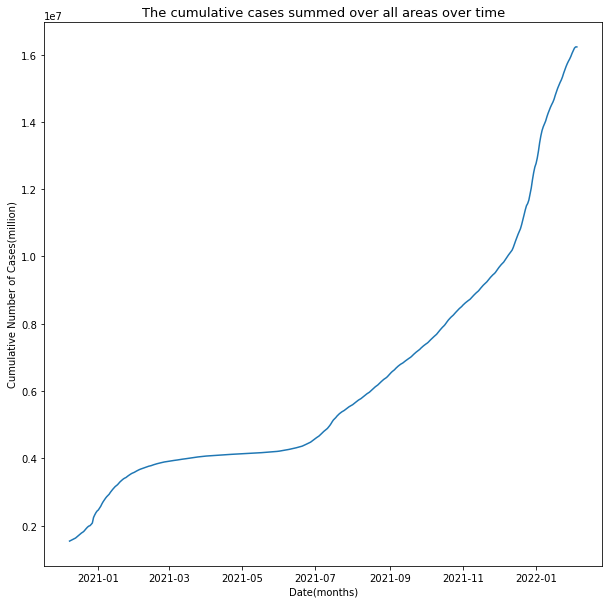

In [17]:
# 1. data aggregation - grouping by date and summing over areas
all_cumulative_cases = covid_data[['date','area','cumulative_cases']]
all_cumulative_cases = all_cumulative_cases.groupby(by="date").sum()
all_cumulative_cases.reset_index(inplace=True)

# 2. plotting
plt.figure(figsize=(10,10))
plt.plot(all_cumulative_cases['date'],all_cumulative_cases['cumulative_cases'])
plt.title("The cumulative cases summed over all areas over time",size=13)
plt.xlabel("Date(months)")
plt.ylabel("Cumulative Number of Cases(million)")
plt.show()

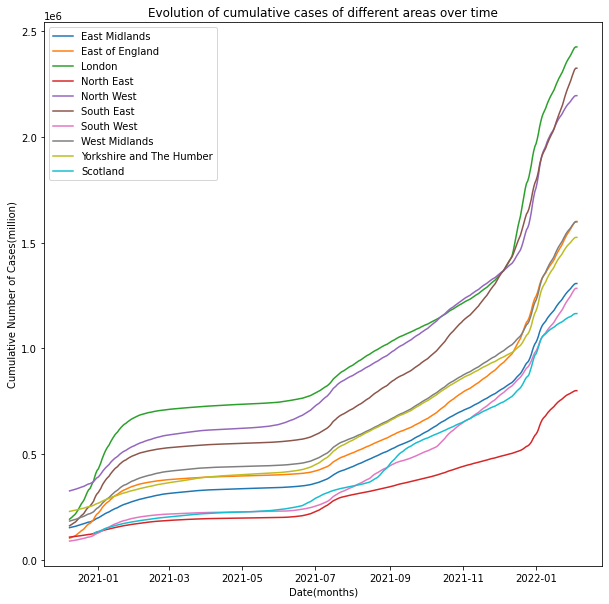

In [18]:
# 1 & 2 - the aggregation and most of the plotting is done in 'plot_area_data' function
plot_area_data(covid_data, "cumulative_cases")
plt.title("Evolution of cumulative cases of different areas over time")
plt.xlabel("Date(months)")
plt.ylabel("Cumulative Number of Cases(million)")
plt.legend()
plt.show()


In July 2021, the UK was beginning it's third wave of Coronivirus pandemic. A new Delta variant had just arrived in the UK and it was more then twice as transmissible compared to previous variants[1], this lead to a increased number of cases around the UK. Furthermore, In the UK, on July 19th 2021 the government lifted all restrictions including wearing of masks and social distancing[2], this meant the virus transmission rate went up as more people went out and socialised. 

The months of June-July fall in summer time is the UK and therefore more people
are outdoors as there are more events scheduled around this time of the year, which further increased the transmission probability of the virus. This higher rate of virus contraction was also reinforced by the fact that a month earlier (May-2021) the govenment had lifted restrictions on holidays and imposed a traffic light system. this meant that UK was more vulnerable to new strand of Covid from other countries
and a greater chance of transmission between nations. 

[1] https://www.cdc.gov/coronavirus/2019-ncov/variants/delta-variant.html

[2] https://www.bbc.co.uk/news/uk-57882029

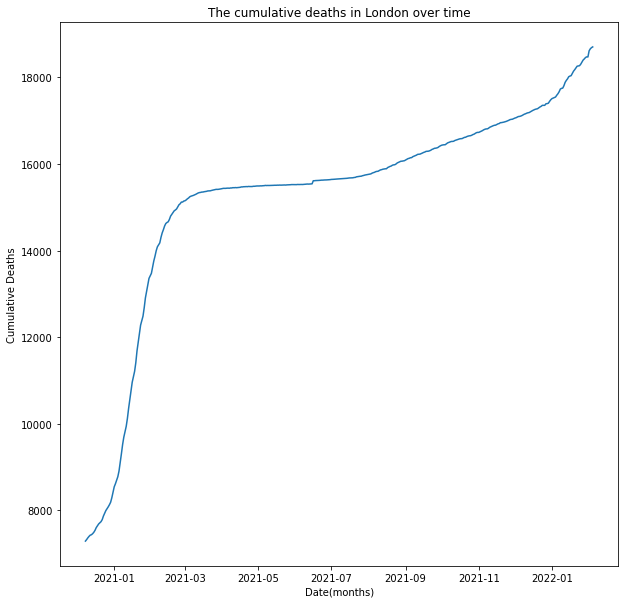

In [19]:
# 1. data aggregation 
cumulative_deaths = covid_data[['date','area','cumulative_deaths']]
cumulative_deaths_london = cumulative_deaths[cumulative_deaths["area"]=="London"]

# 2. Plotting
plt.figure(figsize=(10,10))
plt.plot(cumulative_deaths_london["date"],cumulative_deaths_london["cumulative_deaths"])
plt.title("The cumulative deaths in London over time")
plt.xlabel("Date(months)")
plt.ylabel("Cumulative Deaths")
plt.show()

Yes, There is a similarity between trends in cumulative cases and cumulative deaths in London as both plots follow a similar pattern over time. we can see that at the beginning of the year 2021 both number of cases and number of deaths rise rapidly, then both of them plateau at around March/April 2021, then rise again at around July/August 2021. In both plots we can also see that
towards the end of the year 2021 the rate of increase becomes higher for both cumulative deaths 
and comulative cases in London.

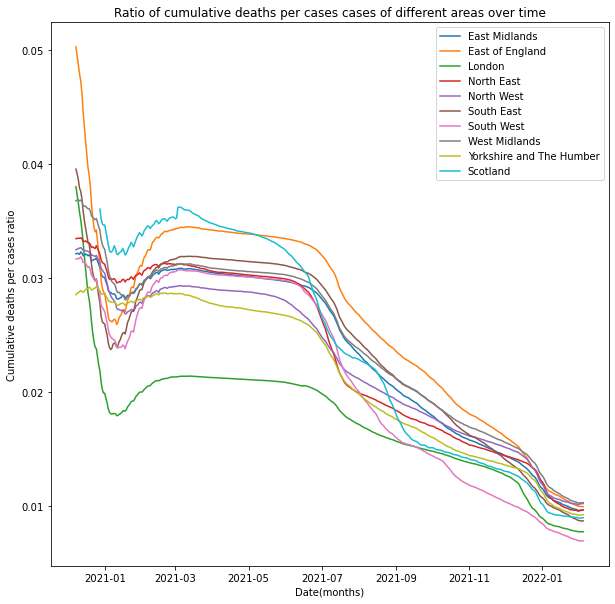

In [20]:
# 1. data aggregation - creating a new column called "cumulative_deaths_per_cases" 
covid_data['cumulative_deaths_per_cases'] = (covid_data["cumulative_deaths"]
                                             /covid_data["cumulative_cases"])

# 2. Plotting the data
plot_area_data(covid_data, "cumulative_deaths_per_cases")
plt.title("Ratio of cumulative deaths per cases cases of different areas over time")
plt.xlabel("Date(months)")
plt.ylabel("Cumulative deaths per cases ratio")
plt.legend()
plt.show()

The Overall trend that we can observe in this plot is that the ratio
of cumulative deaths per cases is falling over time across all areas 
of the UK. We can observe that at the beginning of 2021 there is a sharp
decrease in the ratio in most areas until january-2021 followed a brief  
increase after which the graph plateaus around March-2021 to August-2021
before falling rapidly again in all regions of the UK until the end of the year.

In June 2021, UK saw its first zero daily deaths since the Covid-19 pandemic started[1]. Soon after 75% of UK adult population were reported
as having received at least one dose of the covid-19 vaccine[2] and 50% had also received the second dose[3]. By the end of July-2021 these percentages were about 70% and 60% respectively. This rapid vaccine rollout and administration in the UK meant that although there was an increase in number of infections the number of deaths remained relatively low. 

[1] https://www.bbc.co.uk/news/uk-57320320

[2] https://www.independent.co.uk/news/uk/home-news/covid-vaccine-uk-first-dose-b1858279.html

[3] https://www.bbc.co.uk/news/uk-57346760


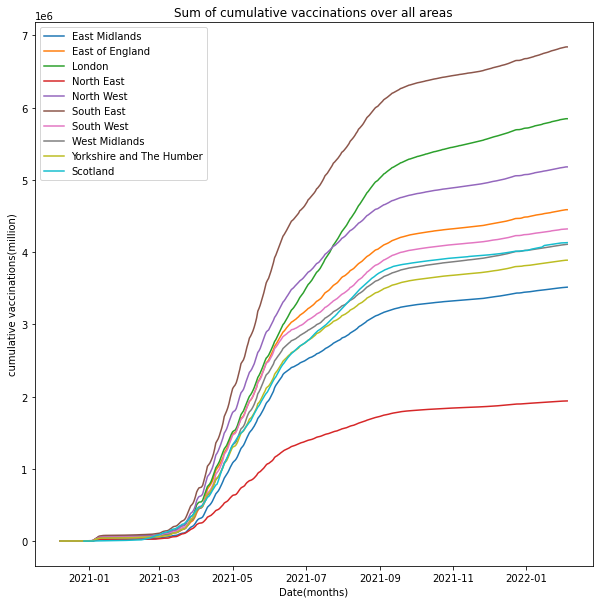

In [21]:
# 1. data aggregation - sum of cumulative vaccinations over all areas.
df_vaccinated = covid_data[['date','area','cumulative_vaccinated']]
df_vaccination = df_vaccinated.groupby(by=["date","area"]).sum()
df_vaccination.reset_index(inplace=True)

# 2. Plotting the data
plt.figure(figsize=(10,10))
plt.title("Sum of cumulative vaccinations over all areas")
plt.xlabel("Date(months)")
plt.ylabel("cumulative vaccinations(million)")
areas = df_vaccination['area'].unique()
for area in areas:
    filter_area = df_vaccination[df_vaccination["area"]==str(area)]
    plt.plot(filter_area['date'],filter_area["cumulative_vaccinated"],
             label=str(area))
    plt.legend(loc="upper left")
plt.show()


The general relationship between the two is that as the comulative vaccination increases across different parts of the UK we can observe that the cumulative deaths per cases decreases. We can also see that even when the rate of comulative vaccination is slowing down or plateauing the cumulative deaths per cases does not slow down,this is because when the graph starts plateauing in the latter part of 2021 people in the most vonerable groups like the elderly or people in care homes
have already been vaccinated. therefore, it seems to be the case that widespread vaccination signifcantly inhibits the spread and mortality rate of the virus.

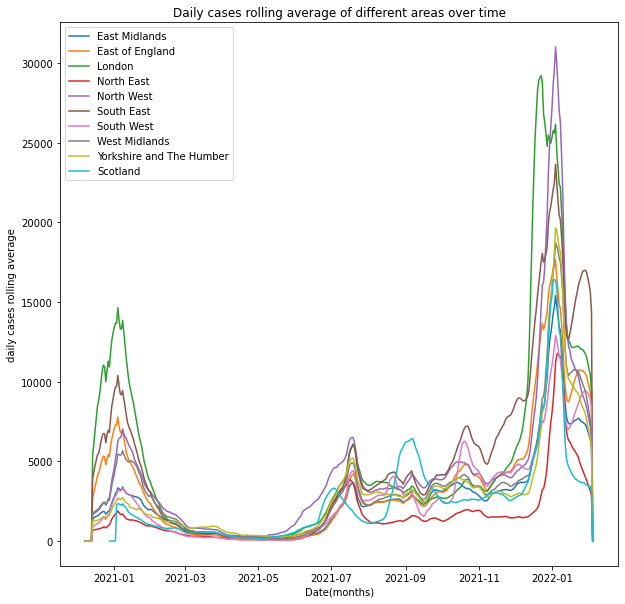

In [22]:
# 1 & 2 - the aggregation and most of the plotting is done by the 'plot_area_data' function
# we are plotting daily cases rolling average as a function of time, separated by areas
plot_area_data(covid_data, "daily_cases_roll_avg")
plt.title("Daily cases rolling average of different areas over time")
plt.xlabel("Date(months)")
plt.ylabel("daily cases rolling average")
plt.legend()
plt.show()

Scotland seems to escapes general trend as we can see around July/August 2021 
the daily cases rolling average came down ealier for Scotland when the number of 
cases in other areas were going up and later in September/October 2021 the daily cases 
rolling average increased then decreased in Scotland whereas it stayed relatively
constant in all other areas of the UK.

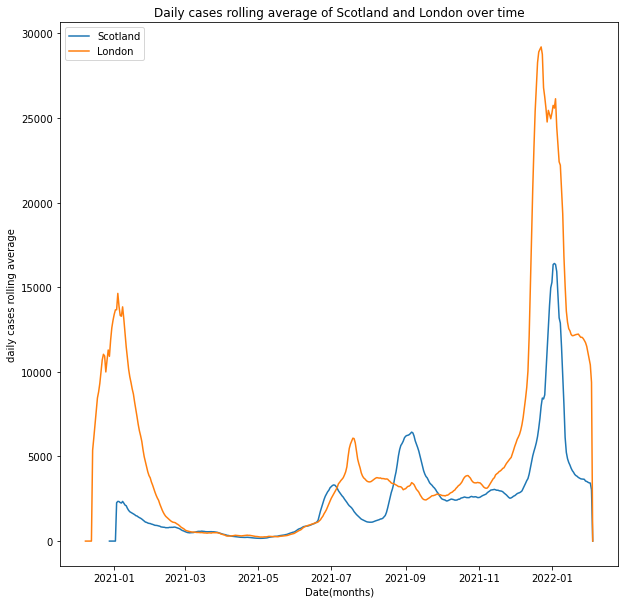

In [23]:
# 1. data aggregation 
df_rolling = covid_data[['date','area','daily_cases_roll_avg']]
df_rolling_avg = df_rolling.groupby(by=["date","area"]).sum()
df_rolling_avg.reset_index(inplace=True)

# 2. Plotting the data
plt.figure(figsize=(10,10))
areas = ["Scotland", "London"]
for area in areas:
    df_area = df_rolling_avg[df_rolling_avg["area"]==str(area)]
    plt.plot(df_area['date'],df_area["daily_cases_roll_avg"],label=str(area))
    plt.legend(loc="best")
plt.title("Daily cases rolling average of Scotland and London over time")
plt.xlabel("Date(months)")
plt.ylabel("daily cases rolling average")
plt.show()


In July 2021 when almost all of the restriction were lifted in
England, Scotland had eased its restrictions but did not lift them completely,
this meant that Scotland had better protection generally and specifically against
the new Delta variant and therfore we can see that around that time cases were actually
going down in Scotland in constrast to London. When it comes to the second point of 
difference around september-2021 the rise of covid cases in Scotland in that 
period might be due to the fact that on 9th of August 2021 Scotland lifted most of the 
remaining restrictions and this may have cause a greater rate if transmission leading to 
a higher number of cases. Therefore around that time we can see an increase in daily 
cases rolling average in Scotland while cases remained relatively constant in London.

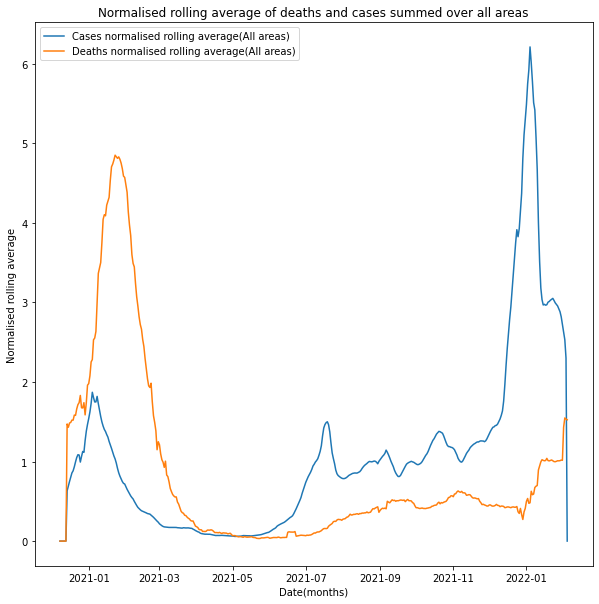

In [24]:
# 1. data aggregation - creating two new normalised columns
covid_data["daily_cases_roll_avg_norm"] = (covid_data['daily_cases_roll_avg']
                                           /covid_data['daily_cases_roll_avg'].max())
covid_data["daily_deaths_roll_avg_norm"] = (covid_data['daily_deaths_roll_avg']
                                            /covid_data['daily_deaths_roll_avg'].max())

df_norm_rolling = covid_data[['date','area','daily_cases_roll_avg_norm','daily_deaths_roll_avg_norm']]
df_norm_rolling = df_norm_rolling.groupby(by=["date"]).sum()
df_norm_rolling.reset_index(inplace=True)

# 2. Plotting the data
plt.figure(figsize=(10,10))
plt.plot(df_norm_rolling['date'], df_norm_rolling['daily_cases_roll_avg_norm'], 
         label="Cases normalised rolling average(All areas)")
plt.plot(df_norm_rolling['date'], df_norm_rolling['daily_deaths_roll_avg_norm'],
         label="Deaths normalised rolling average(All areas)")
plt.title("Normalised rolling average of deaths and cases summed over all areas")
plt.xlabel("Date(months)")
plt.ylabel("Normalised rolling average")
plt.legend(loc="best")
plt.show()

The daily trends of cases and deaths are increasing and decreasing at different
rates, since we can see around January-2021 the normalised rolling average of deaths
is increasing at a much faster rate then the normalised rolling average of cases.
In around June/July 2021 period we can also see that the rate of increase in 
cases is faster then Deaths. This can also be seen at the end of 2021 when
there is a larger and faster increase in normalised rolling average of cases 
compared to normalised rolling average of deaths.

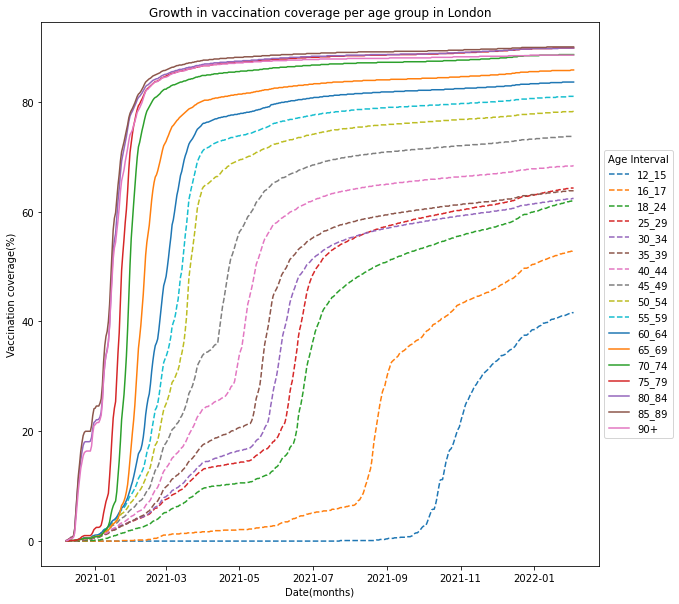

In [25]:
# 1. data aggregation - covid_data_vaccinations_wide
# sometimes the API produces 'NaN' values for the most up-to-date values, I have noticed
# that for the date in when this code is executed it produces 'NaN' values therefore 
# to avoid errors I will drop those rows from the data(this is often the last date rows)
covid_data_vaccinations_wide = covid_data_vaccinations_wide.dropna()
# Taking the "London" and "Scotland" data from "covid_data_vaccinations_wide"
covid_vax_london_filt = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"]=="London"]
covid_vax_scotland_filt = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"]=="Scotland"]

# transforming the "London" data so that each columns are age interval and rows are dates.
long_column_name = 'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'
covid_vax_london = (covid_vax_london_filt[['date', 'age', str(long_column_name)]]
                    .pivot(index='date', columns='age', values=str(long_column_name)))

# 2. Plotting the data for London
plt.figure(figsize=(10,10))
for index, age_group in enumerate(covid_vax_london.columns):
    if index<10:
        plt.plot(covid_vax_london[str(age_group)],
                 label=str(age_group),linestyle="--")
    else:
        plt.plot(covid_vax_london[str(age_group)],
                label=str(age_group))

plt.title("Growth in vaccination coverage per age group in London")
plt.xlabel("Date(months)")
plt.ylabel("Vaccination coverage(%)")
plt.legend(title="Age Interval",loc='center left', bbox_to_anchor=(1.0, 0.5))  
plt.show()

All age groups were not vaccinated equally, older people had received their
first dose of vaccination earlier then younger people as we can see that, for example 
the rate vaccination coverage(for first dose) raises much faster for 90+ age group 
then those in lower  age intrvals like 18-24 years old. for example, By the time 18-24 
year olds reached around 10% vaccination coverage, over 80% of people in 85-89 age bracket were vaccinated. Even within the elderly the stategy of vaccinating the oldest and most 
vulnerable people first was employed. This suggest a priority based vaccination stategy where 
groups that are most vunerable(elderly and other medically vunerable) are vaccinated first. 

This stategy was employed because the older a person is the more likely they are to reach 
a critical condition when they contract covid-19 as well as being more likely to die from it.
therefore the stategy of vaccinating the elderly and the most vulnerable was employed to 
minimise the number of deaths due to covid.

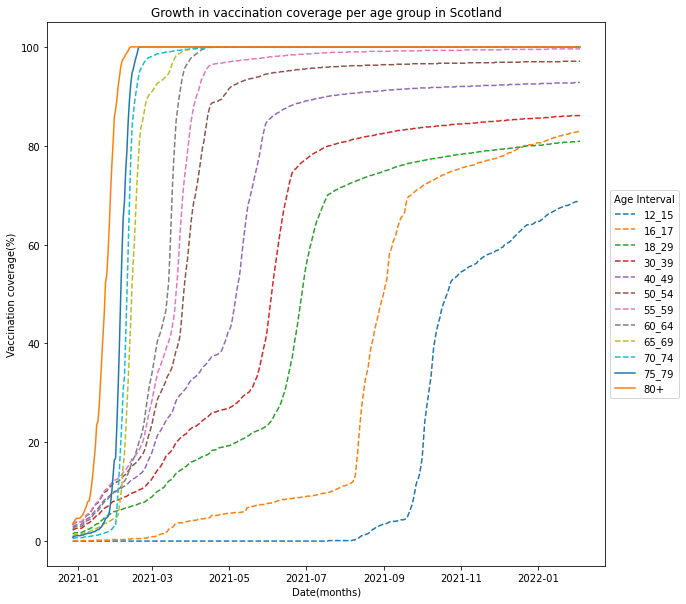

In [26]:
# 1. data aggregation 
long_column_name = 'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'
covid_vax_scotland_filt = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"]=="Scotland"]
covid_vax_scotland = (covid_vax_scotland_filt[['date', 'age',str(long_column_name)]]
                      .pivot(index='date', columns='age', values=str(long_column_name)))

# 2. Plotting the data for Scotland
plt.figure(figsize=(10,10))
for index, age_group in enumerate(covid_vax_scotland.columns):
    if index<10:
        plt.plot(covid_vax_scotland[str(age_group)],
                 label=str(age_group),linestyle="--")
    else:
        plt.plot(covid_vax_scotland[str(age_group)],
                label=str(age_group))
        
plt.title("Growth in vaccination coverage per age group in Scotland")
plt.xlabel("Date(months)")
plt.ylabel("Vaccination coverage(%)")
plt.legend(title="Age Interval",loc='center left', bbox_to_anchor=(1.0, 0.5))  
plt.show()


Focusing on London first, we can see that the age group 65-79 were vaccinated
before the 50-64 age group as the lines for 65-79 group starts raising before
50-64 age group. we can also see that in London for both sections of population
the vaccine coverage percentage rose very quickly at the beginning of year 2021 before it start plateauing, however we can see that for the age group 65-79 the
vaccine uptake rose faster and earlier and it also plateaus earlier and at higher coverage 
percentage level. we can observe in the London plot that the the younger the age group 
the slower and later the rise in vaccination coverage. for example by March-2021 the vaccine
coverage for the age group 65-79 had reached alomst 80%, however the vaccine coverage
for the 50-64 age group in the same time was only around 65%. We can also observe that the
younger the age bracket the lower the coverage percentage at which the lines starts plateauing.

For Scotland we can see a similar trend to London. However Scotland seems to have applied
a different strategy as the vaccine coverage for the the 50-64 age group is raising faster and
earlier at the beginning of vaccine rollout in January then the 65-79 age group. Another difference
that can be observed between Scotland and London is that in Scotland we can see the vaccine
coverage for the 65-79 age group reaches 100% and by the end of the year 2021 it reaches almost
100% for the 50-64 age group as well, a milestone unattained by any of the age groups in London. 

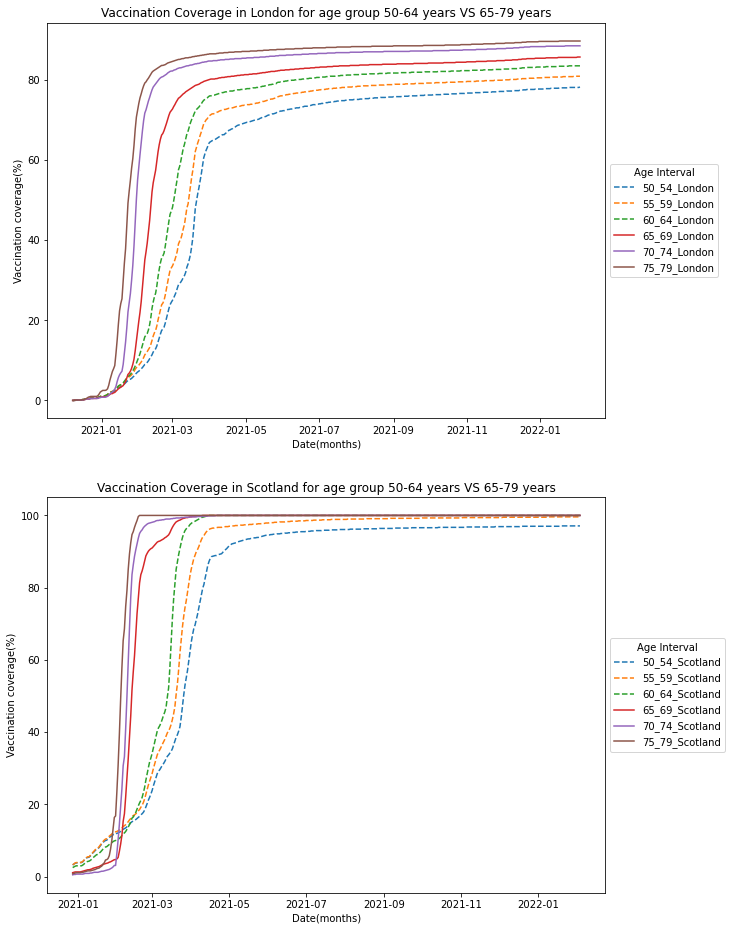

In [27]:
# comparing Scotland and London data
fig, ax = plt.subplots(2,1, figsize=(10,16))
# 1- Firstly we will plot the graph for both age intervals for London
age_groups = ['50_54', '55_59', '60_64','65_69', '70_74', '75_79']

for index, age_group in enumerate(age_groups):
    if index<3:
        ax[0].plot(covid_vax_london[str(age_group)],
                 label=str(age_group+'_London'),linestyle="--")
    else:
        ax[0].plot(covid_vax_london[str(age_group)],
                 label=str(age_group+'_London'))
       
ax[0].set_xlabel("Date(months)")
ax[0].set_ylabel("Vaccination coverage(%)")
ax[0].legend(title="Age Interval",loc='center left', bbox_to_anchor=(1.0, 0.5))  
ax[0].set_title("Vaccination Coverage in London for age group 50-64 years VS 65-79 years")

# 2- Now, we will plot the graph for both age intervals for Scotland
for index, age_group in enumerate(age_groups):
    if index<3:
        ax[1].plot(covid_vax_scotland[str(age_group)],
                 label=str(age_group+'_Scotland'),linestyle="--")
    else:
        ax[1].plot(covid_vax_scotland[str(age_group)],
                 label=str(age_group+'_Scotland'))
    
ax[1].set_xlabel("Date(months)")
ax[1].set_ylabel("Vaccination coverage(%)")
ax[1].legend(title="Age Interval",loc='center left', bbox_to_anchor=(1.0, 0.5))  
ax[1].set_title("Vaccination Coverage in Scotland for age group 50-64 years VS 65-79 years")
plt.show()